# EDA for the Multimodal Single-Cell Integration Competition

In [1]:
import os, gc, scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from colorama import Fore, Back, Style
from sklearn.decomposition import TruncatedSVD

DATA_DIR = "/kaggle/input/open-problems-multimodal/"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

A little trick to save time with pip: On the first run of the notebook, we need to install the `tables` module with pip. If the module is already installed (after a restart of the notebook, for instance), pip wastes 10 seconds by checking whether a newer version exists. We can skip this check by testing for the presence of the module in a simple if statement.

In [2]:
%%time
# If you see a warning "Failed to establish a new connection" running this cell,
# go to "Settings" on the right hand side, 
# and turn on internet. Note, you need to be phone verified.
# We need this library to read HDF files.
if not os.path.exists('/opt/conda/lib/python3.7/site-packages/tables'):
    !pip install --quiet tables


CPU times: user 290 ms, sys: 58.5 ms, total: 348 ms
Wall time: 14.1 s


# The metadata table

The metadata table (which describes training and test data) shows us:
- There is data about 281528 unique cells.
- The cells belong to five days, four donors, eight cell types (including one type named 'hidden'), and two technologies.
- The metadata table has no missing values.

**Insight:** 
- Every cell is used only on a single day and then discarded. There are no time series over single cells.
- The two technologies do not share cells. It looks like we may create two completely independent models, one per technology, even if they share the same four donors. It's two Kaggle competitions in one!
- As the models are independent, it is a good idea to work with two separate notebooks, one for CITEseq, the other one for Multiome.
- Donor and cell_type are categorical features, which can be one-hot encoded. 

In [3]:
df_meta = pd.read_csv(FP_CELL_METADATA, index_col='cell_id')
display(df_meta)
if not df_meta.index.duplicated().any(): print('All cell_ids are unique.')
if not df_meta.isna().any().any(): print('There are no missing values.')
    

,day,donor,cell_type,technology
cell_id,,,,
c2150f55becb,2,27678,HSC,citeseq
65b7edf8a4da,2,27678,HSC,citeseq
c1b26cb1057b,2,27678,EryP,citeseq
917168fa6f83,2,27678,NeuP,citeseq
2b29feeca86d,2,27678,EryP,citeseq
...,...,...,...,...
96a60b026659,10,31800,hidden,multiome
d493e546991e,10,31800,hidden,multiome
05666c99aa48,10,31800,hidden,multiome


All cell_ids are unique.
There are no missing values.


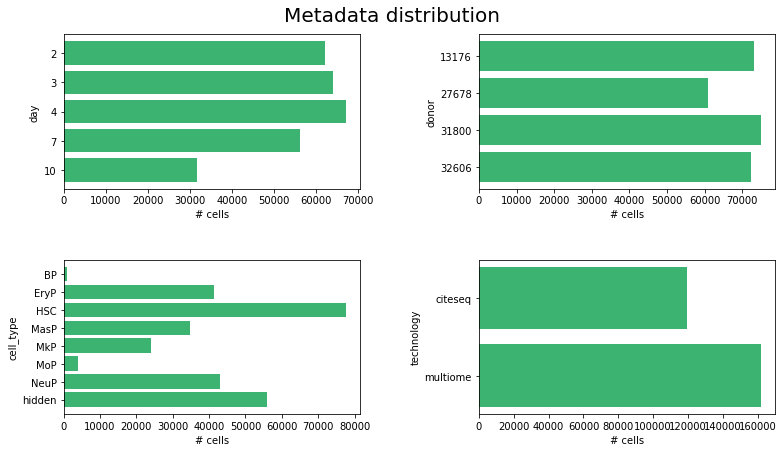

In [4]:
_, axs = plt.subplots(2, 2, figsize=(11, 6))
for col, ax in zip(['day', 'donor', 'cell_type', 'technology'], axs.ravel()):
    vc = df_meta[col].astype(str).value_counts()
    if col == 'day':
        vc.sort_index(key = lambda x : x.astype(int), ascending=False, inplace=True)
    else:
        vc.sort_index(ascending=False, inplace=True)
    ax.barh(vc.index, vc, color=['MediumSeaGreen'])
    ax.set_ylabel(col)
    ax.set_xlabel('# cells')
plt.tight_layout(h_pad=4, w_pad=4)
plt.suptitle('Metadata distribution', y=1.04, fontsize=20)
plt.show()


The CITEseq measurements took place on four days, the Multiome measurements on five (except that there are no measurements for donor 27678 on day 4. For every combination of day, donor and technology, there are around 8000 cells:

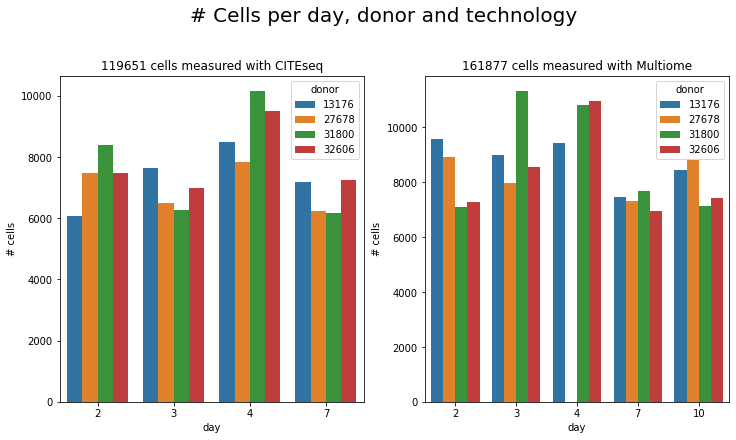

Average: 8044


In [5]:
# From https://www.kaggle.com/code/peterholderrieth/getting-started-data-loading
df_meta_cite = df_meta[df_meta.technology=="citeseq"]
df_meta_multi = df_meta[df_meta.technology=="multiome"]

fig, axs = plt.subplots(1,2,figsize=(12,6))
df_cite_cell_dist = df_meta_cite[["day","donor"]].value_counts().to_frame()\
                .sort_values("day").reset_index()\
                .rename(columns={0:"# cells"})
sns.barplot(data=df_cite_cell_dist, x="day",hue="donor",y="# cells", ax=axs[0])
axs[0].set_title(f"{len(df_meta_cite)} cells measured with CITEseq")

df_multi_cell_dist = df_meta_multi[["day","donor"]].value_counts().to_frame()\
                .sort_values("day").reset_index()\
                .rename(columns={0:"# cells"})
sns.barplot(data=df_multi_cell_dist, x="day",hue="donor",y="# cells", ax=axs[1])
axs[1].set_title(f"{len(df_meta_multi)} cells measured with Multiome")
plt.suptitle('# Cells per day, donor and technology', y=1.04, fontsize=20)
plt.show()
print('Average:', round(len(df_meta) / 35))

A diagram (taken from the [competition homepage](https://www.kaggle.com/competitions/open-problems-multimodal/data)) illustrates the relationships:
- In the CITEseq competition, we train on data for three donors and three days. For the public leaderboard, we predict the fourth donor; for the private leaderboard, we predict another day for all donors.
- In the Multiome competition, we train on three donors and four days. For the public leaderboard, we predict the fourth donor; for the private leaderboard, we predict a fifth day.

**Insight:** As the data is grouped and we have to predict unseen groups (the last donor or the last day), we might choose `GroupKFold` as cross-validation scheme.

![Diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F4308072%2F23e8c1f6faea1453998544cdc116a20e%2FNeurIPS%202022%20-%20Frame%204.jpg?generation=1660755395301873&alt=media)

# CITEseq inputs

We start by looking at CITEseq, which has the smaller datafiles than Multiome and is more tractable.

The CITEseq input files contain 70988 samples (i.e., cells) for train and 48663 samples for test. 70988 + 48663 = 119651, which matches the number of rows in the CITEseq metadata table. No values are missing.

The input data corresponds to RNA expression levels for 22050 genes (there are 22050 columns).

The data have dtype float32, which means we need 119651 * 22050 * 4 = 10553218200 bytes = 10.6 GByte of RAM just for the features (train and test) without the targets. 

Originally, these RNA expression levels were counts (i.e., nonnegative integers), but they have been normalized and log1p-transformed. With the log1p transformation, the data remain nonnegative.

Most columns have a minimum of zero, which means that for most genes there are cells which didn't express this gene (the count was 0). In fact, 78 % of all table entries are zero, and for some columns, the count is always zero.

**Insight:**
- This is big data. Make sure you don't waste RAM and use efficient algorithms.
- Perhaps we should first load only the training data into RAM, fit one or more models, and then delete the training data from RAM before loading the test data.
- The columns which are zero for every cell should be dropped before modeling.

In [6]:
%%time
# Analyze train features
df_cite_train_x = pd.read_hdf(FP_CITE_TRAIN_INPUTS)
display(df_cite_train_x.head())
print('Shape:', df_cite_train_x.shape)
print("Missing values:", df_cite_train_x.isna().sum().sum())
print("Genes which never occur in train:", (df_cite_train_x == 0).all(axis=0).sum())
print(f"Zero entries in train: {(df_cite_train_x == 0).sum().sum() / df_cite_train_x.size:.0%}")
cite_gene_names = list(df_cite_train_x.columns)

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,4.090185,0.0
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.00000,0.000000,0.000000,0.0
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.0,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.00000,3.847321,3.847321,0.0
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.0,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.00000,3.436846,4.113780,0.0
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.0,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.51861,4.196826,3.518610,0.0


Shape: (70988, 22050)
Missing values: 0
Genes which never occur in train: 449
Zero entries in train: 78%
CPU times: user 46.5 s, sys: 10.5 s, total: 57 s
Wall time: 1min 8s


The distribution of the zeros can be visualized with the pyplot `spy()` function. This function plots a black dot for every nonzero entry of the array. The resulting image shows us that the differences between the columns are substantial: some columns are almost white (i.e., they contain mostly zeros), others are dark (i.e., they contain a lot of nonzero values).

The rows of the matrix look homogeneous.

**Insight:** Maybe we can exploit the column differences for feature selection.

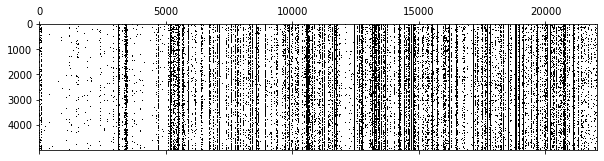

In [7]:
plt.figure(figsize=(10, 4))
plt.spy(df_cite_train_x[:5000])
plt.show()

The histogram shows some artefacts because the data originally were integers. We don't show the zeros in the histogram, because with 78 % zeros, the histogram would have such a high peak at zero that we couldn't see anything else.

**Insight:** The feature values are either 0 or between 2.9 and 12 - the distribution is far away from normal. If we apply statistical tests, this fact has to be taken into consideration.

Minimum nonzero value: 2.9715922


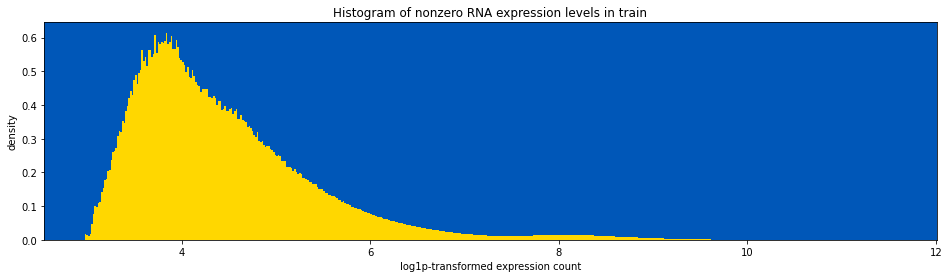

CPU times: user 36.3 s, sys: 4.39 s, total: 40.6 s
Wall time: 40.5 s


In [8]:
%%time
nonzeros = df_cite_train_x.values.ravel()
nonzeros = nonzeros[nonzeros != 0] # comment this line if you want to see the peak at zero
plt.figure(figsize=(16, 4))
plt.gca().set_facecolor('#0057b8')
plt.hist(nonzeros, bins=500, density=True, color='#ffd700')
print('Minimum nonzero value:', nonzeros.min())
del nonzeros
plt.title("Histogram of nonzero RNA expression levels in train")
plt.xlabel("log1p-transformed expression count")
plt.ylabel("density")
plt.show()

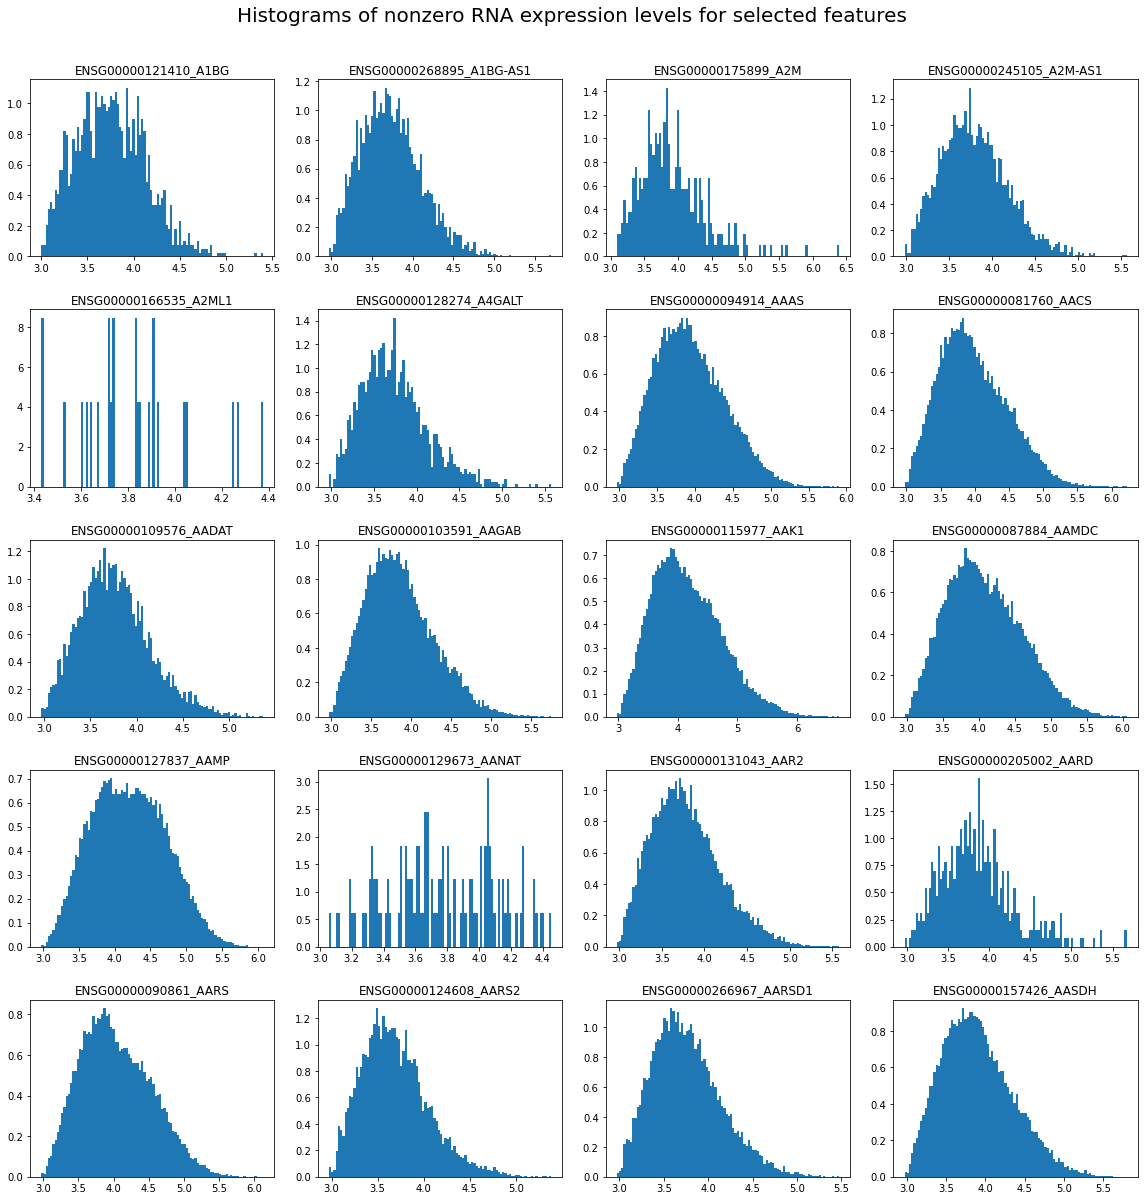

In [9]:
_, axs = plt.subplots(5, 4, figsize=(16, 16))
for col, ax in zip(df_cite_train_x.columns[:20], axs.ravel()):
    nonzeros = df_cite_train_x[col].values
    nonzeros = nonzeros[nonzeros != 0] # comment this line if you want to see the peak at zero
    ax.hist(nonzeros, bins=100, density=True)
    ax.set_title(col)
plt.tight_layout(h_pad=2)
plt.suptitle('Histograms of nonzero RNA expression levels for selected features', fontsize=20, y=1.04)
plt.show()
del nonzeros

As we have seen that most entries of df_cite_train_x are zero and memory is scarce, we convert the numpy array to a [compressed sparse row](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) (CSR) matrix:

In [10]:
cell_index = df_cite_train_x.index
meta = df_meta_cite.reindex(cell_index)
gc.collect()
df_cite_train_x = scipy.sparse.csr_matrix(df_cite_train_x.values)


We have freed enough memory to analyze the test data; afterwards we convert the test data to a CSR matrix as well.

In [11]:
df_cite_test_x = pd.read_hdf(FP_CITE_TEST_INPUTS)
print('Shape of CITEseq test:', df_cite_test_x.shape)
print("Missing values:", df_cite_test_x.isna().sum().sum())
print("Genes which never occur in test: ", (df_cite_test_x == 0).all(axis=0).sum())
print(f"Zero entries in test:  {(df_cite_test_x == 0).sum().sum() / df_cite_test_x.size:.0%}")


gc.collect()
cell_index_test = df_cite_test_x.index
meta_test = df_meta_cite.reindex(cell_index_test)
df_cite_test_x = scipy.sparse.csr_matrix(df_cite_test_x.values)


Shape of CITEseq test: (48663, 22050)
Missing values: 0
Genes which never occur in test:  745
Zero entries in test:  78%


# The data leak

It has been pointed out in several discussion posts (the first one was [CITEseq data: same RNA expression matrices from different donors in day2?](https://www.kaggle.com/competitions/open-problems-multimodal/discussion/349867) by @gwentea) that the first 7476 rows of test (day 2, donor 27678) are identical to the first 7476 rows of train (day 2, donor 32606):


In [12]:
print('Data leak:', (df_cite_train_x[:7476] == df_cite_test_x[:7476]).toarray().all())

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Data leak: True


**Insight:**
- Some mistake happened when the data was prepared; it can't be that 7476 cells of one donor return exactly the same measurements as 7476 cells of another donor.
- These rows belong to the public test set; the private test set is not affected.
- Kaggle has decided to exclude the 7476 wrong cells from scoring, see [this discussion](https://www.kaggle.com/competitions/open-problems-multimodal/discussion/350933).
- (Before that decision, one had to copy the 7476 rows from the training targets into the test predictions to get a good score.)

# The distributions of train and test in feature space

For the next diagrams, we need to project the data (train and test together) to two dimensions. Usually I'd do that with a PCA, but the scikit-learn PCA implementation needs too much memory. Fortunately, TruncatedSVD does a similar projection and uses much less memory:

In [13]:
# Concatenate train and test for the SVD
both = scipy.sparse.vstack([df_cite_train_x, df_cite_test_x])
print(f"Shape of both before SVD: {both.shape}")

# Project to two dimensions
svd = TruncatedSVD(n_components=2, random_state=1)
both = svd.fit_transform(both)
print(f"Shape of both after SVD:  {both.shape}")

# Separate train and test
X = both[:df_cite_train_x.shape[0]]
Xt = both[df_cite_train_x.shape[0]:]


Shape of both before SVD: (119651, 22050)
Shape of both after SVD:  (119651, 2)


The scatterplots below show the extent of the data for every day and every donor (SVD projection to two dimensions). The nine diagrams with orange dots make up the training data. The three diagrams with orange-red dots below are the public test set and the four dark red diagrams at the right are the private test set.

The gray area marks the complete training data (union of the nine orange diagrams), and the black area behind marks the test data.

We see that the distributions differ. In particular the day 2 distribution (left column of diagrams) is much less wide than the others.

**Insight:**
- For the public test we predict a previously unseen donor, for the private test a previously unseen day. This situation suggests that we use a GroupKFold for cross-validation, although its unclear whether we should group on day, donor, or both. 
- Every small diagram consists of only 8000 samples and the data is noisy. It will be difficult not to overfit.
- As the public test set is three times smaller than the training dataset, we must not rely on the public leaderboard to evaluate models. 
- Day 7 (private test) covers areas of the feature space which occur neither in train nor in public test. We'll need a model which can extrapolate to this area, and the public leaderboard will give us no clue about the quality of this extrapolation.
- The diagrams confirm the data leak described above: The lower two diagrams of day 2 are identical.

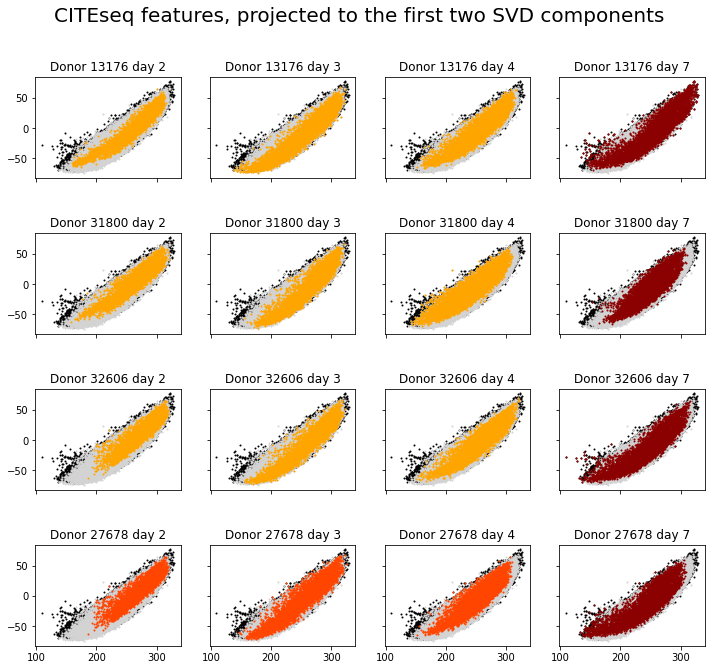

In [14]:
# Scatterplot for every day and donor
_, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12, 11))
for donor, axrow in zip([13176, 31800, 32606, 27678], axs):
    for day, ax in zip([2, 3, 4, 7], axrow):
        ax.scatter(Xt[:,0], Xt[:,1], s=1, c='k')
        ax.scatter(X[:,0], X[:,1], s=1, c='lightgray')
        if day != 7 and donor != 27678: # train
            temp = X[(meta.donor == donor) & (meta.day == day)]
            ax.scatter(temp[:,0], temp[:,1], s=1, c='orange')
        else: # test
            temp = Xt[(meta_test.donor == donor) & (meta_test.day == day)]
            ax.scatter(temp[:,0], temp[:,1], s=1, c='darkred' if day == 7 else 'orangered')
        ax.set_title(f'Donor {donor} day {day}')
        ax.set_aspect('equal')
plt.suptitle('CITEseq features, projected to the first two SVD components', y=0.95, fontsize=20)
plt.show()


In [15]:
df_cite_train_x, df_cite_test_x, X, Xt = None, None, None, None # release the memory

# CITEseq targets (surface protein levels)

The CITEseq output (target) file is much smaller - it has 70988 rows like the training input file, but only 140 columns. The 140 columns correspond to 140 proteins.

The targets are dsb-normalized surface protein levels. We plot the histograms of a few selected columns and see that the distributions vary: some columns are normally distributed, some columns are multimodal, some have other shapes, and there seem to be outliers.

**Insight:**
- This is a multi-output regression problem with 140 outputs. We won't be able to apply some standard methods of single-output regression - e.g., we can't compute the correlation between every feature and the target. 
- As the targets are so diverse, a one-size-fits-all approach might not give the best results.

gene_id,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,1.167804,0.622530,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,-0.448390,3.220174,-0.533004,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.548070
d02759a80ba2,0.818970,0.506009,1.078682,6.848758,3.524885,5.279456,4.930438,2.069372,0.333652,-0.468088,...,0.323613,8.407108,0.131301,0.047607,-0.243628,0.547864,1.832587,0.982308,2.736507,2.184063
c016c6b0efa5,-0.356703,-0.422261,-0.824493,1.137495,0.518924,7.221962,-0.375034,1.738071,0.142919,-0.971460,...,1.348692,4.888579,-0.279483,-0.131097,-0.177604,-0.689188,9.013709,-1.182975,3.958148,2.868600
ba7f733a4f75,-1.201507,0.149115,2.022468,6.021595,7.258670,2.792436,21.708519,-0.137913,1.649969,-0.754680,...,1.504426,12.391979,0.511394,0.587863,-0.752638,1.714851,3.893782,1.799661,1.537249,4.407671
fbcf2443ffb2,-0.100404,0.697461,0.625836,-0.298404,1.369898,3.254521,-1.659380,0.643531,0.902710,1.291877,...,0.777023,6.496499,0.279898,-0.841950,-0.869419,0.675092,5.259685,-0.835379,9.631781,1.765445


Output shape: (70988, 140)


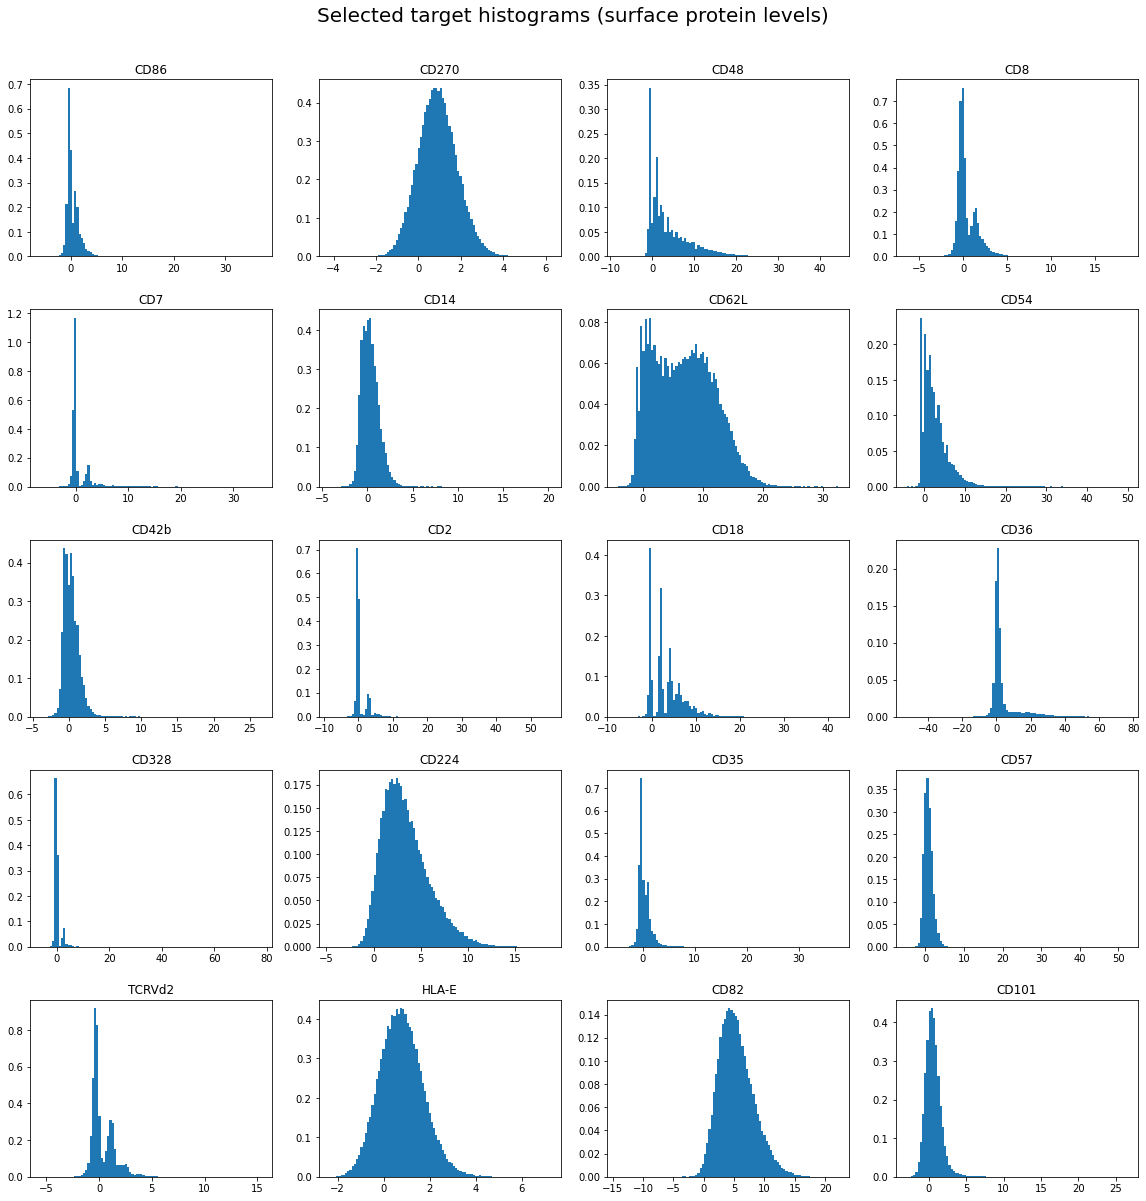

In [16]:
df_cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
display(df_cite_train_y.head())
print('Output shape:', df_cite_train_y.shape)

_, axs = plt.subplots(5, 4, figsize=(16, 16))
for col, ax in zip(['CD86', 'CD270', 'CD48', 'CD8', 'CD7', 'CD14', 'CD62L', 'CD54', 'CD42b', 'CD2', 'CD18', 'CD36', 'CD328', 'CD224', 'CD35', 'CD57', 'TCRVd2', 'HLA-E', 'CD82', 'CD101'], axs.ravel()):
    ax.hist(df_cite_train_y[col], bins=100, density=True)
    ax.set_title(col)
plt.tight_layout(h_pad=2)
plt.suptitle('Selected target histograms (surface protein levels)', fontsize=20, y=1.04)
plt.show()

cite_protein_names = list(df_cite_train_y.columns)

A projection of the CITEseq targets to two dimensions again shows that the groups have different distributions.

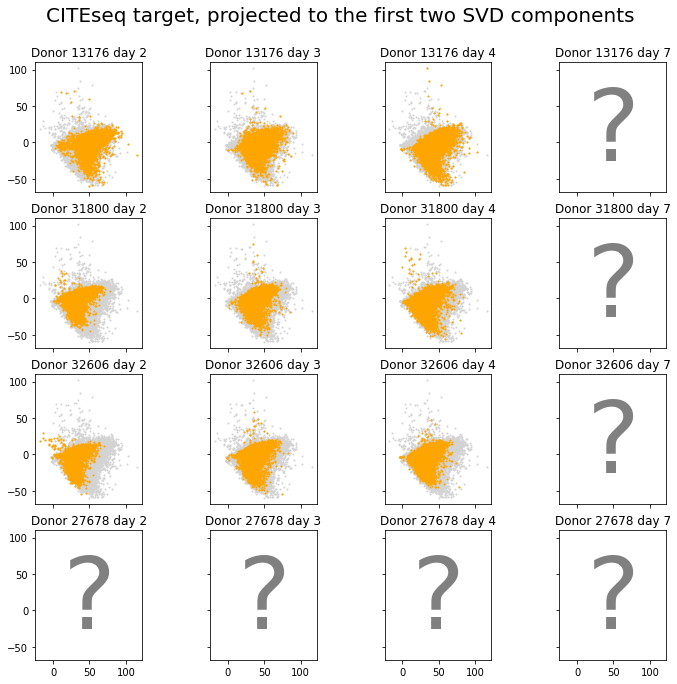

In [17]:
svd = TruncatedSVD(n_components=2, random_state=1)
X = svd.fit_transform(df_cite_train_y)

# Scatterplot for every day and donor
_, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12, 11))
for donor, axrow in zip([13176, 31800, 32606, 27678], axs):
    for day, ax in zip([2, 3, 4, 7], axrow):
        if day != 7 and donor != 27678: # train
            ax.scatter(X[:,0], X[:,1], s=1, c='lightgray')
            temp = X[(meta.donor == donor) & (meta.day == day)]
            ax.scatter(temp[:,0], temp[:,1], s=1, c='orange')
        else: # test
            ax.text(50, -25, '?', fontsize=100, color='gray', ha='center')
        ax.set_title(f'Donor {donor} day {day}')
        ax.set_aspect('equal')
plt.suptitle('CITEseq target, projected to the first two SVD components', y=0.95, fontsize=20)
plt.show()

In [18]:
df_cite_train_x, df_cite_train_y, X, svd = None, None, None, None # release the memory

# Name matching

The CITEseq task has genes as input and proteins as output. Genes encode proteins, and it is more or less known which genes encode which proteins. This information is encoded in the column names: The input dataframe has the genes as column names, and the target dataframe has the proteins as column names. According to the naming convention, the gene names contain the protein name as suffix after a '_'. 

If we match the input column names with the target column names, we find 151 genes which encode a target protein (see the table below). It doesn't matter that some proteins are encoded by more than one gene (e.g., rows 146 and 147 of the table). We may assume that these 151 features will have a high feature importance in our models. 

**Insight:** If we apply dimensionality reduction (PCA, SVD, whatever) to the 22050 features, we should make sure that we don't reduce away the 151 features which encode the proteins we want to predict.

In [19]:
matching_names = []
for protein in cite_protein_names:
    matching_names += [(gene, protein) for gene in cite_gene_names if protein in gene]
pd.DataFrame(matching_names, columns=['Gene', 'Protein'])

,Gene,Protein
0,ENSG00000114013_CD86,CD86
1,ENSG00000120217_CD274,CD274
2,ENSG00000196776_CD47,CD47
3,ENSG00000117091_CD48,CD48
4,ENSG00000101017_CD40,CD40
...,...,...
146,ENSG00000102181_CD99L2,CD9
147,ENSG00000223773_CD99P1,CD9
148,ENSG00000204592_HLA-E,HLA-E
149,ENSG00000085117_CD82,CD82


# Multiome input

The Multiome dataset is much larger than the CITEseq part and way too large to fit into 16 GByte RAM:
- train inputs:  105942 * 228942 float32 values (97 GByte)
- train targets: 105942 *  23418 float32 values (10 GByte)
- test inputs:    55935 * 228942 float32 values (13 GByte)

For this EDA, we read all the data to check for missing, zero and negative values, we plot a histogram and we look at the Y chromosome, but we don't analyze much more.

No values are missing.

The data consists of ATAC-seq peak counts transformed with [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html). They are all nonnegative. In the sample we are looking at, 98 % of the entries are zero.

**Insight:**
- The Multiome data is even bigger data than the CITEseq data. Most of us can't afford notebooks with 97 GByte RAM.
- Dimensionality reduction and feature selection will be key to get successful models.
- Maybe we can do something with sparse array data structures.
- Maybe we can train on a subset of the rows (and sacrifice some precision).
- Maybe we can convert the data to float16.
- We should never have training and test data in memory at the same time.
- We may even want to look for algorithms which don't need all the training data in RAM at the same time. Neural networks are a candidate.
- The columns which are zero for every cell should be dropped before modeling.
- The training set has n_features > n_samples. We'll use algorithms which can deal with more features than samples.


In [20]:
%%time
bins = 100
cell_summary = pd.DataFrame()

def analyze_multiome_x(filename):
    global cell_summary
    start = 0
    chunksize = 5000
    total_rows = 0
    maximum_x = 0

    while True: # read the next chunk of the file
        X = pd.read_hdf(filename, start=start, stop=start+chunksize)
        if X.isna().any().any(): print('There are missing values.')
        if (X < 0).any().any(): print('There are negative values.')
        total_rows += len(X)
        print(total_rows, 'rows read')

        donors = df_meta_multi.donor.reindex(X.index) # metadata: donor of cell
        days = df_meta_multi.day.reindex(X.index) # metadata: day of cell
        chrY_cols = [f for f in X.columns if 'chrY' in f]
        maximum_x = max(maximum_x, X[chrY_cols].values.ravel().max())
        for donor in [13176, 31800, 32606, 27678]:
            hist, _ = np.histogram(X[chrY_cols][donors == donor].values.ravel(), bins=bins, range=(0, 15))
            chrY_histo[donor] += hist

        cell_summary = pd.concat([cell_summary,
                                  pd.DataFrame({'donor': donors,
                                                'day': days,
                                                'total': X.sum(axis=1),
                                                'total_nonzero': (X != 0).sum(axis=1)})])
        if len(X) < chunksize: break
        start += chunksize

    display(X.head(3))
    print(f"Zero entries in {filename}: {(X == 0).sum().sum() / X.size:.0%}")

chrY_histo = dict()
for donor in [13176, 31800, 32606, 27678]:
    chrY_histo[donor] = np.zeros((bins, ), int)

# Look at the training data
analyze_multiome_x(FP_MULTIOME_TRAIN_INPUTS)

5000 rows read
10000 rows read
15000 rows read
20000 rows read
25000 rows read
30000 rows read
35000 rows read
40000 rows read
45000 rows read
50000 rows read
55000 rows read
60000 rows read
65000 rows read
70000 rows read
75000 rows read
80000 rows read
85000 rows read
90000 rows read
95000 rows read
100000 rows read
105000 rows read
105942 rows read


gene_id,GL000194.1:114519-115365,GL000194.1:55758-56597,GL000194.1:58217-58957,GL000194.1:59535-60431,GL000195.1:119766-120427,GL000195.1:120736-121603,GL000195.1:137437-138345,GL000195.1:15901-16653,GL000195.1:22357-23209,GL000195.1:23751-24619,...,chrY:7722278-7723128,chrY:7723971-7724880,chrY:7729854-7730772,chrY:7731785-7732664,chrY:7810142-7811040,chrY:7814107-7815018,chrY:7818751-7819626,chrY:7836768-7837671,chrY:7869454-7870371,chrY:7873814-7874709
cell_id,,,,,,,,,,,,,,,,,,,,,
13cb628b8773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0803092e6b4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.082841,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e8e7ff56f262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Zero entries in /kaggle/input/open-problems-multimodal/train_multi_inputs.h5: 98%
CPU times: user 11min 1s, sys: 1min 11s, total: 12min 12s
Wall time: 11min 31s


In the histogram, we again hide the peak for the 98 % zero values:

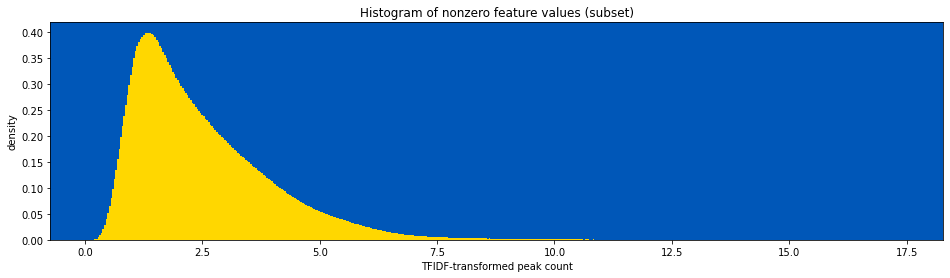

In [21]:
df_multi_train_x = pd.read_hdf(FP_MULTIOME_TRAIN_INPUTS, start=0, stop=5000)
nonzeros = df_multi_train_x.values.ravel()
nonzeros = nonzeros[nonzeros != 0] # comment this line if you want to see the peak at zero
plt.figure(figsize=(16, 4))
plt.gca().set_facecolor('#0057b8')
plt.hist(nonzeros, bins=500, density=True, color='#ffd700')
del nonzeros
plt.title("Histogram of nonzero feature values (subset)")
plt.xlabel("TFIDF-transformed peak count")
plt.ylabel("density")
plt.show()

del df_multi_train_x # free the memory

We do the same checks for the test data:

In [22]:
%%time
# Look at the test data
analyze_multiome_x(FP_MULTIOME_TEST_INPUTS)


5000 rows read
10000 rows read
15000 rows read
20000 rows read
25000 rows read
30000 rows read
35000 rows read
40000 rows read
45000 rows read
50000 rows read
55000 rows read
55935 rows read


gene_id,GL000194.1:114519-115365,GL000194.1:55758-56597,GL000194.1:58217-58957,GL000194.1:59535-60431,GL000195.1:119766-120427,GL000195.1:120736-121603,GL000195.1:137437-138345,GL000195.1:15901-16653,GL000195.1:22357-23209,GL000195.1:23751-24619,...,chrY:7722278-7723128,chrY:7723971-7724880,chrY:7729854-7730772,chrY:7731785-7732664,chrY:7810142-7811040,chrY:7814107-7815018,chrY:7818751-7819626,chrY:7836768-7837671,chrY:7869454-7870371,chrY:7873814-7874709
cell_id,,,,,,,,,,,,,,,,,,,,,
079ddaa2be77,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43ee19ddefb3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f82d95f0637f,0.0,0.0,0.0,2.372443,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Zero entries in /kaggle/input/open-problems-multimodal/test_multi_inputs.h5: 97%
CPU times: user 5min 56s, sys: 39.8 s, total: 6min 36s
Wall time: 6min 20s


# Batch effects

Biological experiments are notorious for batch effects: If you repeat the same experiment several times, you get systematic differences in the measurements. We can show these batch effects for the ATACseq measurements. Because of the huge data size, we look only at the row sums of the data (i.e. the sum of all measured values of a cell). In the diagram, we plot these sums for every row of the train and test datasets, and we color the dots by the day of the experiment (day 2 is red, day 3 is green and so on).

The diagram clearly shows that day 3 (green) gave the highest measurements, day 7 (yellow) the lowest. There are differences among donors as well, albeit smaller ones.

**Insight:**
- We should try to normalize the data in a preprocessing step so that the batch effects don't affect the predictions.
- Because the batch effects depend more on the day than on the donor, we should use a `GroupKFold` on days for cross-validation to validate that the differences between the days don't break the model.

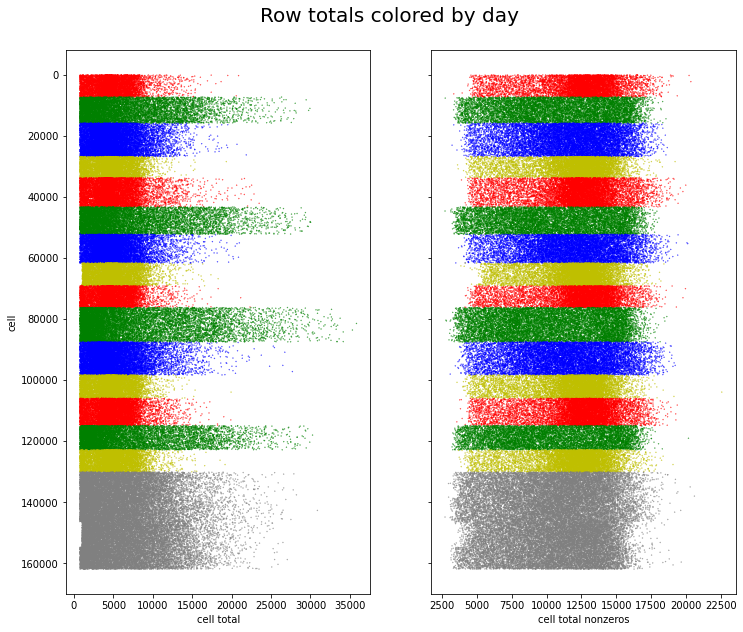

In [23]:
def plot_batch_effects():
    _, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 10))
    color = cell_summary.day.map({2: 'r', 3: 'g', 4: 'b', 7: 'y', 10: 'gray'})
    axs[0].scatter(cell_summary.total_nonzero, np.arange(len(cell_summary)), s=0.1, c=color)
    axs[0].set_xlabel('cell total')
    axs[1].scatter(cell_summary.total, np.arange(len(cell_summary)), s=0.1, c=color)
    axs[1].set_xlabel('cell total nonzeros')
    axs[0].set_ylabel('cell')
    axs[0].invert_yaxis()
    plt.suptitle('Row totals colored by day', y=0.94, fontsize=20)
    plt.show()
    
plot_batch_effects()

# The Y chromosome

Let's plot a histogram of the nonzero values of the Y chromosome for every donor. 

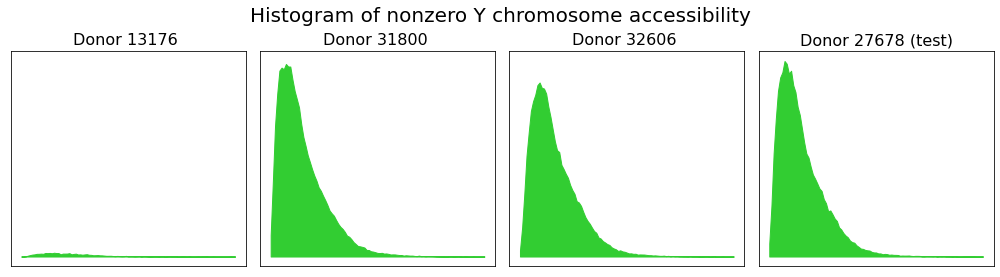

In [24]:
plt.rcParams['savefig.facecolor'] = "1.0"
_, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(14, 4))
for donor, ax in zip([13176, 31800, 32606, 27678], axs):
    ax.set_title(f"Donor {donor} {'(test)' if donor == 27678 else ''}", fontsize=16)
    total = chrY_histo[donor].sum()
    ax.fill_between(range(bins-1), chrY_histo[donor][1:] / total, color='limegreen')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Histogram of nonzero Y chromosome accessibility", y=0.95, fontsize=20)
plt.tight_layout()
plt.show()

The histograms of the Y chromosomes illustrate the diversity of the donors: Donor 13176 seems to have (almost) no Y chromosome (maybe the few nonzero values are measuring errors). It appears that the donors are one woman and three men.

**Insight:**
- If we assume that the true values of donor 13176 are all zero, these data show us the magnitude of the measurement error.
- Maybe we can create a new (binary) feature for the presence of the Y chromosome.
- The diagram reminds us that the donors are different and that our model should be robust to these differences.

# Multiome target

The Multiome targets (RNA count data) are in similar shape as the CITEseq inputs: They have 105942 rows and 23418 columns. All targets are nonnegative and no values are missing.


In [25]:
%%time
cell_summary = pd.DataFrame()
start = 0
chunksize = 10000
total_rows = 0
while True:
    df_multi_train_y = pd.read_hdf(FP_MULTIOME_TRAIN_TARGETS, start=start, stop=start+chunksize)
    if df_multi_train_y.isna().any().any(): print('There are missing values.')
    if (df_multi_train_y < 0).any().any(): print('There are negative values.')
    total_rows += len(df_multi_train_y)
    print(total_rows, 'rows read')

    donors = df_meta_multi.donor.reindex(df_multi_train_y.index) # metadata: donor of cell
    days = df_meta_multi.day.reindex(df_multi_train_y.index) # metadata: day of cell
    cell_summary = pd.concat([cell_summary,
                              pd.DataFrame({'donor': donors,
                                            'day': days,
                                            'total': df_multi_train_y.sum(axis=1),
                                            'total_nonzero': (df_multi_train_y != 0).sum(axis=1)})])
    
    if len(df_multi_train_y) < chunksize: break
    start += chunksize
    
display(df_multi_train_y.head())


10000 rows read
20000 rows read
30000 rows read
40000 rows read
50000 rows read
60000 rows read
70000 rows read
80000 rows read
90000 rows read
100000 rows read
105942 rows read


gene_id,ENSG00000121410,ENSG00000268895,ENSG00000175899,ENSG00000245105,ENSG00000166535,ENSG00000256661,ENSG00000184389,ENSG00000128274,ENSG00000094914,ENSG00000081760,...,ENSG00000086827,ENSG00000174442,ENSG00000122952,ENSG00000198205,ENSG00000198455,ENSG00000070476,ENSG00000203995,ENSG00000162378,ENSG00000159840,ENSG00000074755
cell_id,,,,,,,,,,,,,,,,,,,,,
1777f8908031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,6.271747,0.0,0.000000,0.000000,0.000000
7b88c4c3021b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,4.251612,0.000000,0.0,0.0,5.627168,0.0,0.000000,4.251612,5.340685
34f17c8aece8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,5.349229,0.0,0.0,0.000000,0.0,4.660822,5.753109,0.000000
f02fabdccd4b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.606937,4.606937,...,0.000000,4.606937,0.000000,0.0,0.0,4.606937,0.0,0.000000,0.000000,0.000000
6083c6994d3e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,4.245897,0.000000,4.245897,0.0,0.0,0.000000,0.0,0.000000,0.000000,4.931858


CPU times: user 1min 5s, sys: 8.51 s, total: 1min 14s
Wall time: 1min 38s


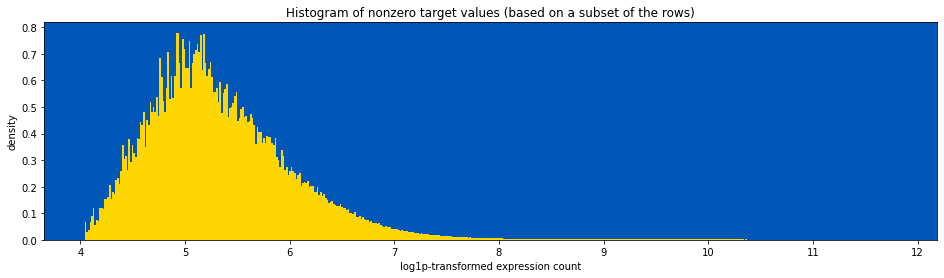

CPU times: user 2.61 s, sys: 312 ms, total: 2.92 s
Wall time: 2.68 s


In [26]:
%%time
nonzeros = df_multi_train_y.values.ravel()
nonzeros = nonzeros[nonzeros != 0]
plt.figure(figsize=(16, 4))
plt.gca().set_facecolor('#0057b8')
plt.hist(nonzeros, bins=500, density=True, color='#ffd700')
del nonzeros
plt.title("Histogram of nonzero target values (based on a subset of the rows)")
plt.xlabel("log1p-transformed expression count")
plt.ylabel("density")
plt.show()

df_multi_train_y = None # release the memory

Above, we saw the batch effects in the ATACseq data; below we see that the gene expression dataset has its own, independent, batch effects: For the gene expression data, day 7 (yellow) clearly has the lowest totals. Day 3 (green), which deviated the most from the other days for the ATACseq data, is not far from the mean for the gene expressions. But again, differences among days seem to exceed differences among donors.

The good news here is that the competition metric does not depend on shifts in the target values: Even if for day 7 (and maybe for day 10) all measurements are shifted by a constant, the predictions can still achieve a good correlation with the true values. With a mean-squared-error metric, this would be different.

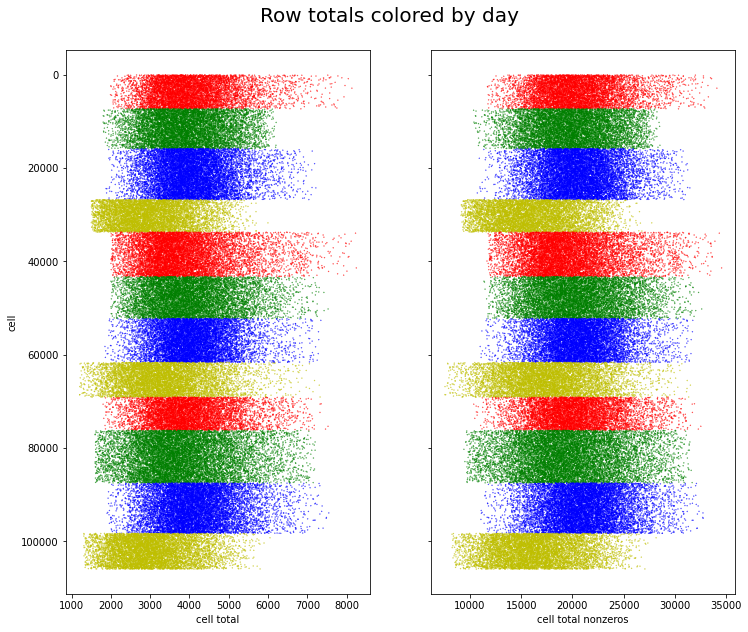

In [27]:
plot_batch_effects()

# Summary

- This is a big data competition. The more RAM you have, the better. In any case, you'll have to treat RAM as a scarce resource and write memory-efficient code.
- As there are two competitions in one, you can choose to participate in only one of them (and merge your predictions with somebody else's predictions for the other part). CITEseq is easier to begin with.
- Make sure you decide for a good cross-validation scheme so that you avoid the shakedown at the end of the competition.

After this EDA, you may want to look at some models which generate predictions in spite of having only 16 GB RAM:
- [MSCI CITEseq Keras Quickstart](https://www.kaggle.com/code/ambrosm/msci-citeseq-keras-quickstart)
- [MSCI CITEseq Quickstart](https://www.kaggle.com/ambrosm/msci-citeseq-quickstart) (using LightGBM)
- [MSCI Multiome Quickstart](https://www.kaggle.com/ambrosm/msci-multiome-quickstart) (using ridge regression)